In [16]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import sys
sys.path.append('../')

In [13]:
from src.utils import show_prompt
from src.prompt import logistics_agent_tasks
show_prompt(logistics_agent_tasks, "logistics_agent_tasks")

╭───────────────────────────────────────────── logistics_agent_tasks ─────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the Logistics Data received so far:                                                                  │
│                                                                                                                 │
│  <agent_brief>                                                                                                  │
│  {agent_brief}                                                                                                  │
│  </agent_brief>                                                                                                 │
│                                                                                                                 │
│  <field_specifications>                                                                                         │
│  {fields_details}                                                                                               │
│  </field_specifications>                                                                                        │
│                                                                                                                 │
│  <mandatory_fields>                                                                                             │
│  {mandatory_fields}                                                                                             │
│  </mandatory_fields>                                                                                            │
│                                                                                                                 │
│  <optional_fields>                                                                                              │
│  {optional_fields}                                                                                              │
│  </optional_fields>                                                                                             │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Your role is to act as the logistician Agent in the Inbound Logistics system.                                  │
│  Your responsibilities are:                                                                                     │
│                                                                                                                 │
│  <Instructions>                                                                                                 │
│  1. **Extract Information:** - Parse the provided data and extract values for all available schema fields       │
│  2. **Identify Missing Fields:**                                                                                │
│     - Record any missing mandatory fields in `"missing_mandatory_fields"`                                       │
│     - Record any missing optional fields in `"missing_optional_fields"`                                         │
│  3. **Field Mapping:** - Map extracted values to the corresponding schema fields. Use null if missing, e.g:     │
│     - `"AWB/BL"`: The unique Air Waybill or Bill of Lading number for the shipment                              │
│     - `"Product Temperature"`: The temperature conditions required to safely transport and store a product.     │
│     - `"Shipment Mode"`: The method of transporting go

In [4]:
from src.prompt import missing_mandatory_fields_prompt
show_prompt(missing_mandatory_fields_prompt, "missing_mandatory_fields_prompt")

╭──────────────────────────────────────── missing_mandatory_fields_prompt ────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user, informing them about missing required fields. Start right away without     │
│  introduction                                                                                                   │
│                                                                                                                 │
│  ⚠️ **Missing Required Information**                                                                             │
│  I cannot proceed with the {agent} request until the following required fields are provided                     │
│                                                                                                                 │
│  <missing_fields>                                                                                               │
│  {missing_mandatory_fields}                                                                                     │
│  </missing_fields>                                                                                              │
│                                                                                                                 │
│  📌 **Details of Missing Fields**                                                                               │
│  {missing_mandatory_field_details}                                                                              │
│                                                                                                                 │
│  **How to provide the information:**                                                                            │
│  Please share the missing details in a in **clear, structured format**, e.g:                                    │
│                                                                                                                 │
│  - "AWB/BL : ABC123456                                                                                          │
│  - Shipment Mode: Air freight"                                                                                  │
│                                                                                                                 │
│  You may provide them together in JSON-style formatting, or simply list them in your reply.                     │
│                                                                                                                 │
│  💡 **Tip:**                                                                                                    │
│  If you are unsure about any of the required fields or need clarification, just let me know and I’ll guide      │
│  you.                                                                                                           │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [5]:
from src.prompt import missing_optional_fields_prompt
show_prompt(missing_optional_fields_prompt, "missing_optional_fields_prompt")

╭──────────────────────────────────────── missing_optional_fields_prompt ─────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user, informing them about missing optional fields. Start right away without     │
│  introduction                                                                                                   │
│                                                                                                                 │
│  ℹ️ **Additional Information Inquiry**                                                                           │
│  I can process your {agent} request with the current information, but I noticed some optional fields that       │
│  could enhance the completeness of your record:                                                                 │
│                                                                                                                 │
│  <missing_fields>                                                                                               │
│  {missing_optional_fields}                                                                                      │
│  </missing_fields>                                                                                              │
│                                                                                                                 │
│  📌 **Details of Missing Optional Fields**                                                                      │
│  {missing_optional_field_details}                                                                               │
│                                                                                                                 │
│  **Your Options**                                                                                               │
│  - ✅ **Provide the additional information** now → creates a more complete record.                              │
│  - ⏭️ **Skip these fields** and proceed → I’ll continue processing with the current data.                        │
│  - 🕒 **Add them later** → you can update the record once the information is available.                         │
│                                                                                                                 │
│  **How to Provide the optional fields**                                                                         │
│  You can respond in any of these ways:                                                                          │
│  - `"Product_Temperature": "2-8°C cold chain"`                                                                  │
│  - `"Skip optional fields and proceed"`                                                                         │
│  - `"I’ll provide these later"`                                                                                 │
│                                                                                                                 │
│  Would you like to provide any of this optional information, or should I proceed with the current data?         │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
from src.prompt import user_confirmation_prompt
show_prompt(user_confirmation_prompt, "user_confirmation_prompt")

╭─────────────────────────────────────────── user_confirmation_prompt ────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  **GOAL**                                                                                                       │
│  Write a concise message for a user summarizing the final list of fields for confirmation. Start right away     │
│  without introduction                                                                                           │
│                                                                                                                 │
│  ⚠️ **Confirmation Required**                                                                                    │
│                                                                                                                 │
│  Here is the collected {agent} information, including the most recent updates:                                  │
│                                                                                                                 │
│  <information_report>                                                                                           │
│  {information_report}                                                                                           │
│  </information_report>                                                                                          │
│                                                                                                                 │
│  ✅ Please review and confirm if everything is correct so I can proceed with submitting the transaction.        │
│                                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [18]:
%%writefile ../src/ibl_data_source.py

"""
   This data source represent the IBL Schema
"""
import json

def ibl_data_source(path: str , agent: str) -> dict[str : str]:
    try:
        with open(path, "r", encoding="utf-8") as config:
            config_file = json.load(config).get(agent, [])
    except FileNotFoundError:
        print("Error: logistics_schema.json not found. Please create it.")
        exit()
    return config_file

Overwriting ../src/ibl_data_source.py


In [19]:
%%writefile ../src/logistics_schema.py

"""State Definitions and Pydantic Schemas for Logistics Agent.

This defines the state objects and structured schemas used for
the Logistics Agent scoping workflow, including Logistics state management and output schemas.
"""

import operator
from datetime import date
from typing_extensions import Optional , List
from pydantic import BaseModel, Field , create_model
from src.supervisor_schema import AgentState
from src.ibl_data_source import ibl_data_source

# Load logitics fields dynamiclly
logistics_fields = ibl_data_source("./IBL_SCHEMA.json","logistics_agent")

# Dynamically create Pydantic model for shipment fields
DynamicShipmentFields = create_model(
    "DynamicShipmentFields",
    **{
        field_item["field"]: (
            Optional[field_item["dataType"]],  # default type; could later map dataType
            Field(None, description = field_item.get("description", ""))
        )
        for field_item in logistics_fields
    }
)

# ===== STRUCTURED OUTPUT SCHEMAS =====
class LogisticsSchema(BaseModel):
    """Schema for Logisticis Agent."""
    missing_mandatory_fields: List[str] = Field(
        description = "Fields required by the schema that are missing from the provided data"
    )
    missing_optional_fields: List[str] = Field(
        description = "Optional fields that are missing from the provided data"
    )
    ask_for_optional_fields: bool = Field(
        description = "Specifies whether the user should be prompted for optional fields",
        default = True
    )
    needs_user_confirmation: bool = Field(
        description = "Specifies whether user confirmation is required for the current record",
        default = True
    )
    
    shipment : DynamicShipmentFields

# ===== STATE DEFINITIONS =====
class LogisticsState(AgentState):
    """ State for the Logistics Agent """
    agent_response: Optional[LogisticsSchema] = None

Overwriting ../src/logistics_schema.py


In [20]:
%%writefile ../src/ibl_database_update.py
""" This code defines a tool to push records to IBL DB """

import sys
from typing import Dict, Any
from mcp.server.fastmcp import FastMCP
import asyncio

# Initialize FastMCP server
mcp = FastMCP("db-server")

@mcp.tool()
async def UpdateDB(record: Dict[str, Any]) -> Dict[str, Any]:
    """
    Update the IBL database and confirm back.
    
    Args:
        record: Record details of dictionary type.
    
    Returns:
        A dictionary contains a success status and the new record

    """
    try:
        success = True
        return {
                 "status" : f"{success}",
                 "record" : record
               }
    except Exception as e:
        return str(e)

# Main execution
if __name__ == "__main__":
    mcp.run(transport="stdio")

Overwriting ../src/ibl_database_update.py


In [ ]:
%%writefile ../src/logistics_agent.py

"""This code contains the code for the logistician agent"""
import os
import json
from dotenv import load_dotenv
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import SystemMessage , ToolMessage , HumanMessage, AIMessage, get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver
from langchain_mcp_adapters.client import MultiServerMCPClient
from src.prompt import missing_mandatory_fields_prompt, missing_optional_fields_prompt, \
                        user_confirmation_prompt, logistics_agent_tasks
from src.logistics_schema import LogisticsSchema, LogisticsState
from src.ibl_data_source import ibl_data_source

# Load environment variables
load_dotenv()

# Current Date
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# ===== Import Logistics Fields ("Mandatory","Optional") =====
import_logistics_schema = ibl_data_source("./IBL_SCHEMA.json","logistics_agent")

logistics_fields = [
    item for item in import_logistics_schema
]
mandatory_fields = [
    item['field'] for item in import_logistics_schema if item.get('required') is True
]
optional_fields = [
    item['field'] for item in import_logistics_schema if item.get('required') is False
]

def get_selected_field_details(all_fields, missed_fields):
    """
    """
    return [ fields for fields in all_fields if fields in missed_fields]

# ===== MCP Configuration =====
mcp_config = None

try:
    with open ("../mcp_servers.json" , "r") as mcp_file:
        mcp_config = json.load(mcp_file)
except FileNotFoundError:
    print("Error: mcp_servers.json not found. Please create it.")
    exit()

# Global client variable - will be initialized lazily
_client = None

def get_mcp_client():
    """Get or initialize MCP client lazily to avoid issues with LangGraph Platform."""
    global _client
    if _client is None:
        _client = MultiServerMCPClient(mcp_config)
    return _client


# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
summarize_model = model

def logistics_agent(state: LogisticsState) -> Command[Literal["logistics_tools", "ConfirmWithUser", "CommitLogisticsTransaction" , "__end__"]]:
    """
       Logistics Agent assesses whether the received data is adequate to make deterministic decisions 
       about committing the data to the logistics database.
    """
    # Set up structured output model
    structured_output_model = model.with_structured_output(LogisticsSchema)

    # Invoke the model
    response = structured_output_model.invoke([
               HumanMessage(content = logistics_agent_tasks.format(
                                      agent_brief = state["agent_brief"], 
                                      date = get_today_str(),
                                      fields_details = logistics_fields,
                                      mandatory_fields = mandatory_fields,
                                      optional_fields = optional_fields
               ))
    ])
    
    agent_brief_messages = [AIMessage(content = state["agent_brief"])]

    if response.missing_mandatory_fields:        # missing mandatory fields
        return Command(
               goto=END, 
               update={"messages": agent_brief_messages + [model.invoke([AIMessage(content = missing_mandatory_fields_prompt.format(
                                                                                   agent = "Logistics" ,
                                                                                   missing_mandatory_fields = response.missing_mandatory_fields,
                                                                                   missing_mandatory_field_details = get_selected_field_details(all_fields = logistics_fields,
                                                                                                                                                missed_fields = response.missing_mandatory_fields))
                                                     )])]}
        )
    elif response.missing_optional_fields and response.ask_for_optional_fields: # missing optional fields before confirmation
        return Command(
               goto=END, 
               update={"messages": agent_brief_messages + [model.invoke([AIMessage(content = missing_optional_fields_prompt.format(
                                                                                   agent = "Logistics" ,
                                                                                   missing_optional_fields = response.missing_optional_fields,
                                                                                   missing_optional_field_details = get_selected_field_details(all_fields = logistics_fields,
                                                                                                                                              missed_fields = response.missing_optional_fields))
                                                     )])]}
        )
    elif response.needs_user_confirmation: # missing confirmation
        return Command(
               goto = "ConfirmWithUser", 
               update = {"agent_response" : response,
                          "messages" : agent_brief_messages}
        )
    else: # everything is OK and confirmed
        return Command(
               goto = "CommitLogisticsTransaction", 
               update = {"agent_response": response , 
                         "messages" : agent_brief_messages}
        )

def ConfirmWithUser(state: LogisticsState) -> Command[Literal["__end__"]]: 
    """ If there is anything that Logistics Agent needs to confirm with the user """
    # first summarize 
    # system_message = summarize_logistics_system_prompt.format(date=get_today_str())
    # messages = [SystemMessage(content=system_message)] + state.get("messages", []) + [HumanMessage(content=summarize_logistics_human_prompt)]
    # response = summarize_model.invoke(messages)
    # Print the summary requesting confirmation
    return Command(
           goto=END, 
           update={"messages": model.invoke([AIMessage(content = user_confirmation_prompt.format(agent = "Logistics", information_report = state["agent_response"].model_dump()))])}
    )

def logistics_tools(state: LogisticsState):
    """
        Executes all tool calls from the logistics Agent response.
        Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls

    tools =  []
    tools_by_name = {}

    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

async def CommitLogisticsTransaction(state: LogisticsState):
    """ Following the user's confirmation, the logistics database will be updated with the received data """
    
    # Get available tools from MCP server
    client = get_mcp_client()
    tools = await client.get_tools()
    tools_by_name = {tool.name: tool for tool in tools}

    # Get the update database tool
    UpdateDB = tools_by_name["UpdateDB"]

    # Initialize model with tool binding
    # model_with_tools = model.bind_tools(UpdateDB)

    # get the last response which includes all the filled values after confirmation
    response = state["agent_response"]

    # Convert the response into dictionary and delete unnecessary fields
    response_dict = response.model_dump()
    response_dict = {k:v for (k,v) in response_dict.items() if k not in ["missing_mandatory_fields", "missing_optional_fields",
                                                                         "ask_for_optional_fields", "needs_user_confirmation"]}
    # commit the logistics transactions following the confirmation
    confirmation_result = await UpdateDB.ainvoke({"record": response_dict})
    
    return{
            "messages": [AIMessage(content=f"{confirmation_result}")]     # confirm back
    }

# Build the scoping workflow
logistics_agent_builder = StateGraph(LogisticsState)

# Add workflow nodes
logistics_agent_builder.add_node("logistics_agent", logistics_agent)
logistics_agent_builder.add_node("logistics_tools", logistics_tools)
logistics_agent_builder.add_node("ConfirmWithUser", ConfirmWithUser)
logistics_agent_builder.add_node("CommitLogisticsTransaction", CommitLogisticsTransaction)

# Add workflow edges
logistics_agent_builder.add_edge(START, "logistics_agent")
logistics_agent_builder.add_edge("logistics_tools", "logistics_agent")
logistics_agent_builder.add_edge("ConfirmWithUser", END)
logistics_agent_builder.add_edge("CommitLogisticsTransaction", END)

# Compile the workflow
checkpointer = InMemorySaver()
LogisticsAgent = logistics_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/logistics_agent.py


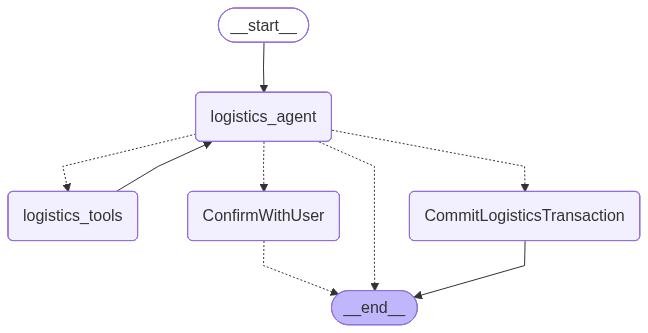

In [12]:
from IPython.display import Image, display
from src.logistics_agent import LogisticsAgent

# Show the agent
display(Image(LogisticsAgent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
from src.logistics_agent import LogisticsAgent
thread = {"configurable":{"thread_id":"1"}}
message = "The shipment AWB/BL is 12345 "
result = await LogisticsAgent.ainvoke({"agent_brief" : message,
                                        "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Fields**                                                                                   │
│                                                                                                                 │
│ To proceed, please provide the following information:                                                           │
│ - AWB/BL Date                                                                                                   │
│ - Shipment Mode                                                                                                 │
│                                                                                                                 │
│ You can reply with the details in this format:                                                                  │
│ - AWB/BL Date:                                                                                                  │
│ - Shipment Mode:                                                                                                │
│                                                                                                                 │
│ If you need help or clarification about these fields, let me know!                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [14]:
message = "Well the AWB/BL is 12345 and Shipment Mode Air."
result = await LogisticsAgent.ainvoke({"agent_brief" : message,
                                "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Fields**                                                                                   │
│                                                                                                                 │
│ To proceed, please provide the following information:                                                           │
│ - AWB/BL Date                                                                                                   │
│ - Shipment Mode                                                                                                 │
│                                                                                                                 │
│ You can reply with the details in this format:                                                                  │
│ - AWB/BL Date:                                                                                                  │
│ - Shipment Mode:                                                                                                │
│                                                                                                                 │
│ If you need help or clarification about these fields, let me know!                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - AWB/BL Date                                                                                                   │
│                                                                                                                 │
│ Please provide the missing information so we can proceed with your request. If you need help or clarification,  │
│ let me know!                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [15]:
message = "Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30"
result = await LogisticsAgent.ainvoke({"agent_brief" : message,
                                "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Fields**                                                                                   │
│                                                                                                                 │
│ To proceed, please provide the following information:                                                           │
│ - AWB/BL Date                                                                                                   │
│ - Shipment Mode                                                                                                 │
│                                                                                                                 │
│ You can reply with the details in this format:                                                                  │
│ - AWB/BL Date:                                                                                                  │
│ - Shipment Mode:                                                                                                │
│                                                                                                                 │
│ If you need help or clarification about these fields, let me know!                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - AWB/BL Date                                                                                                   │
│                                                                                                                 │
│ Please provide the missing information so we can proceed with your request. If you need help or clarification,  │
│ let me know!                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission: Forwarder, Product Temperature, Packing, Shipping Temp,  │
│ Gel Pack Expiry Date, Handover to Clearance, Aggregation, Notified FF Date, Green light - Date, Logistic        │
│ Comment, Remark, and ASN Importation Date.                                                                      │
│                                                                                                                 │
│ You can proceed without them, or provide any of these details now to complete your record. Let me know how      │
│ you’d like to continue!                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [16]:
message = "Well the AWB/BL is 12345 , Shipment Mode Air and AWB/BL Date is 2025-09-30. skip the optional fields"
result = await LogisticsAgent.ainvoke({"agent_brief" : message,
                                       "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ The shipment AWB/BL is 12345                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Fields**                                                                                   │
│                                                                                                                 │
│ To proceed, please provide the following information:                                                           │
│ - AWB/BL Date                                                                                                   │
│ - Shipment Mode                                                                                                 │
│                                                                                                                 │
│ You can reply with the details in this format:                                                                  │
│ - AWB/BL Date:                                                                                                  │
│ - Shipment Mode:                                                                                                │
│                                                                                                                 │
│ If you need help or clarification about these fields, let me know!                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 and Shipment Mode Air.                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ ⚠️ **Missing Required Field:**                                                                                   │
│ - AWB/BL Date                                                                                                   │
│                                                                                                                 │
│ Please provide the missing information so we can proceed with your request. If you need help or clarification,  │
│ let me know!                                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Some optional fields are missing from your submission: Forwarder, Product Temperature, Packing, Shipping Temp,  │
│ Gel Pack Expiry Date, Handover to Clearance, Aggregation, Notified FF Date, Green light - Date, Logistic        │
│ Comment, Remark, and ASN Importation Date.                                                                      │
│                                                                                                                 │
│ You can proceed without them, or provide any of these details now to complete your record. Let me know how      │
│ you’d like to continue!                                                                                         │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 , Shipment Mode Air and AWB/BL Date is 2025-09-30. skip the optional fields            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Well the AWB/BL is 12345 , Shipment Mode Air and AWB/BL Date is 2025-09-30. skip the optional fields            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here is the final list of fields for your confirmation:                                                         │
│                                                                                                                 │
│ **Provided:**                                                                                                   │
│ - AWB/BL: 12345                                                                                                 │
│ - AWB/BL Date: 2025-09-30                                                                                       │
│ - Shipment Mode: Air                                                                                            │
│                                                                                                                 │
│ **Missing (optional):**                                                                                         │
│ - Forwarder                                                                                                     │
│ - Incoterm                                                                                                      │
│ - Product Temperature                                                                                           │
│ - Packing                                                                                                       │
│ - Shipping Temp                                                                                                 │
│ - Gel Pack Expiry Date                                                                                          │
│ - Handover to Clearance                                                                                         │
│ - Aggregation                                                                                                   │
│ - Notified FF Date                                                                                              │
│ - Green light - Date                                                                                            │
│ - Logistic Comment                                                                                              │
│ - Remark                                                                                                        │
│ - ASN Importation Date                                                                                          │
│                                                                                                                 │
│ No mandatory fields are missing.                                                                                │
│                                                                                                                 │
│ Please confirm if this information is correct so I can proceed.                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [17]:
message = "Well the AWB/BL is 12345, Shipment Mode Air and AWB/BL Date is 2025-09-30. skip the optional fields. I am confirming"
result = await LogisticsAgent.ainvoke({"agent_brief" : message,
                                       "messages":[HumanMessage(content=message)]} , config=thread)
format_message(result["messages"])

UnsupportedOperation: fileno